# Exoplanetary Database Comparison

After Exoplanets (planets outside the solar system) are discovered, different groups of researchers use several methods to calculate their parameters (mass, radius, orbital period etc). This results in slightly different numbers for the same parameters of the same planet. These parameters are then stored in databases for easy access by the astronomical community for research purposes. However, due to differences and in how the databases manage and update the data within them and multiple criteria they use to decide if a "planet" is to be included, the databses are bound to have differences within the data they display which ideally should not be the case. 


This project specifically compares and identifies differences in the parameter distributions of mass, radius and orbital period between the following exoplanetary databases:
- NASA Exoplanet Archive (NEA)
- Exoplanet.eu (EU)
- Open Exoplanet Catalogue (OEC)

The outcome of this project are Kernel Density Estimation (KDE) plots that help to visualize differences in the parameter distribution between the databases. A 2-sample Kolmogorov-Smirnov test and Anderson-Darling test are used to quantify distribution differences. Finally, biases and differences revealed are summarized.

NOTE: Ignore "SettingWithCopyWarning" messages when running the code. The analysis sections take about 5s to run per cell.

## NEA Data Cleaning

In [24]:
import numpy as np
import pandas as ps
import re
import sys

# un-truncate arrays
np.set_printoptions(threshold=sys.maxsize)

# Importing CSV to Dataframe
df_NEA = ps.read_csv("NEA_2022.10.16_12.42.34.csv", skiprows=99,
                     usecols=['pl_name', 'pl_refname', 'pl_bmassj', 'pl_radj','pl_orbper'])

df = df_NEA[['pl_name', 'pl_refname', 'pl_bmassj', 'pl_radj', 'pl_orbper']]
df_np = df.to_numpy()  # converts to numpy array

In the NEA database, all published articles referencing a discovered planet and their calculated parameters are listed. This means that the same exoplanet can have multiple entries. These duplicated entries make it difficult to compare the database with other databases. To resolve the issue, all entries for one planet were grouped and the entry referencing the most recent publication (pl_refname) was chosen. See commented code below.

In [25]:
# Creating a way to sort and select most recent pub date
for i in range(0, len(df_np)):
    df_np[i, 1] = re.sub('[^0-9]', '', df_np[i, 1])

# Selecting most recent mass parameters from NEA
BestPar_NEA = []  # Initializing array to store planets with most recent publication
for i in range(0, len(df_np) - 1):
    if df_np[i, 0] != df_np[i + 1, 0]:  # Checking if planet name below is similar to selected planet name
        x = df_np[np.where(df_np[:, 0] == df_np[i, 0])]  # Finds all entries for planet selected and stores in an array
        BestParIdx = np.argmax(x, axis=0)  # Chooses the highest pl_refname number in the array
        BestPar_NEA.append(x[BestParIdx[1]])  # Appends the planet entry selected above to our final array

# most recent Parameter for last object
x = df_np[np.where(df_np[:, 0] == df_np[len(df_np) - 1, 0])]  # Finds all entries for the last planet in database
BestParIdx = np.argmax(x, axis=0)  # Chooses highest pl_refname number for last planet
BestPar_NEA.append(x[BestParIdx[1]])  # Appends planet entry selected to our final array

The code snippet below collects data for all the for the parameters needed and reshapes the array for analysis.

In [26]:
# Array of most recent mass parameters for exoplanets
BestPar_NEAarr = np.asarray(BestPar_NEA)

CD_NEA_namemass = BestPar_NEAarr[:, [0, 2]]  # name + mass
CD_NEA_radorb = BestPar_NEAarr[:, [3, 4]]  # radius + orbital period

# Reshaping array for output
CD_NEA_all = np.concatenate((CD_NEA_namemass, CD_NEA_radorb), axis=1)

CD_NEA_id = []
for i in range(0, len(CD_NEA_all)):
    if CD_NEA_all[i][1] < 13:
        CD_NEA_id.append(CD_NEA_all[i])

df_CD_NEA_id = ps.DataFrame(CD_NEA_id, columns=['name','mass','radius','orbper'])
df_CD_NEA_id.to_csv("CD_NEA_all.csv")

## EU Data Cleaning

In [27]:
import math

# Importing CSV to Dataframe
df_EU = ps.read_csv("EU_2022.10.16.csv", usecols=['# name', 'mass', 'mass_sini','radius','orbital_period'])
df_EU = df_EU.to_numpy()  # converts df to np array

"Mass Sin i" is a lower mass estimate for planets detected via methods that cannot resolve all their parameters. This mass estimate is close enough to the nominal mass of the planet that for the sake of the comparison, we will assume both to be similar. The code snippet below merges the "Mass" and "Mass Sin i" columns.

In [28]:
# Concatenate mass into mass_sini column
for i in range(0, len(df_EU)):
    if math.isnan(df_EU[i, 2]) is True and math.isnan(df_EU[i, 1]) is False:
         df_EU[i, 2] = df_EU[i, 1]

The code snippet below collects data for all the for the parameters needed and reshapes the array for analysis.

In [29]:
CD_EU_namemass = df_EU[:,[0,2]]  # name + mass
CD_EU_radorb = df_EU[:,[3,4]]  # radius + orbper

# Reshaping array for output
CD_EU_all = np.concatenate((CD_EU_namemass,CD_EU_radorb),axis=1)

CD_EU_id=[]
for i in range(0,len(df_EU)):
    if CD_EU_all[i,1]<13:
        CD_EU_id.append(CD_EU_all[i])

df_CD_EU_id = ps.DataFrame(CD_EU_id, columns=['name','mass','radius','orbper'])
df_CD_EU_id.to_csv("CD_EU_all.csv")

## OEC Data Cleaning

In [30]:
import xml.etree.ElementTree as ET, urllib.request, gzip, io

# Read data from OEC git repository
url = "https://github.com/OpenExoplanetCatalogue/oec_gzip/raw/master/systems.xml.gz"
oec = ET.parse(gzip.GzipFile(fileobj=io.BytesIO(urllib.request.urlopen(url).read())))

# Output mass and radius of all planets
OEC = []
for planet in oec.findall(".//planet"):
    A = planet.findtext("name")
    B = planet.findtext("mass")
    C = planet.findtext("radius")
    D = planet.findtext("period")
    OEC.append(A)
    OEC.append(B)
    OEC.append(C)
    OEC.append(D)

Converting all missing data from an empty string to "None" for consistency and easier data manipulation.

In [31]:
for i in range(0, len(OEC)):
    if OEC[i] == '':
        OEC[i] = None

The code snippet below collects data for all the for the parameters needed and reshapes the array for analysis.

In [32]:
# reshape and slice array to reorganize
OECarr = np.array(OEC, dtype=object)
OECarrClean = OECarr.reshape((len(OEC) // 4, 4))  # change when adding parameter
CD_OEC = OECarrClean[:, [0, 3]]
# OECarrMass = OECarrClean[:,1]

CD_OEC = OECarrClean[:, [0, 3]]
CD_OEC_namemass = OECarrClean[:,[0,1]]  # name + mass
CD_OEC_radorb = OECarrClean[:,[2,3]]  # radius + orbper

# Reshaping array for output
CD_OEC_all = np.concatenate((CD_OEC_namemass,CD_OEC_radorb),axis=1)

CD_OEC_id=[]
for i in range(0,len(CD_OEC_all)):
    if CD_OEC_all[i][1] != None:
        if float(CD_OEC_all[i][1]) < 13:
            CD_OEC_id.append(CD_OEC_all[i])
            
            
df_CD_OEC = ps.DataFrame(CD_OEC_id, columns=['name', 'mass','radius', 'orbper'])
df_CD_OEC.to_csv("CD_OEC_all.csv")

## Data Analysis

Because of the different inclusion criteria of all three databases, some planet entries appear in one database and not the other and vice versa. We will be comparing 2 datasets at once to generate p-values for the 2-sample Anderson-Darling test that will be used. We will therefore obtain 3 different subsets as follows:
- Match group (planets appearing in all 3 databases)
- Unique A (Planets only in database A)
- Unique B (Planets only in database B)

For all 3 databases we therefore obtain 9 different subgroups for parameter comparison:
- Match NEA (Parameter of planets appearing in all 3 databases etc.)
- Match EU
- Match OEC
- Unique NEA-EU (Parameter of planets in NEA but not EU)
- Unique EU-NEA (Parameter of planets in EU but not NEA etc.)
- Unique EU-OEC
- Unique OEC-EU
- Unique NEA-OEC
- Unique OEC-NEA

### Mass Parameter 

In [33]:
import seaborn as sns
from scipy.stats import ks_2samp, anderson_ksamp
import matplotlib.pyplot as plt

df_NEA = ps.read_csv("CD_NEA_all.csv")
df_EU = ps.read_csv("CD_EU_all.csv")
df_OEC = ps.read_csv("CD_OEC_all.csv")

Removing capitalization and spaces in exoplanet names to match planet entries between databases. This is needed due to inconsistencies in planetary naming covention across databases.

In [34]:
# Removing capitalization and spaces in names

for i in range(len(df_NEA)):
    df_NEA.name[i] = df_NEA.name[i].replace(" ", "")
    df_NEA.name[i] = df_NEA.name[i].lower()

for i in range(len(df_EU)):
    df_EU.name[i] = df_EU.name[i].replace(" ", "")
    df_EU.name[i] = df_EU.name[i].lower()

for i in range(len(df_OEC)):
    df_OEC.name[i] = df_OEC.name[i].replace(" ", "")
    df_OEC.name[i] = df_OEC.name[i].lower()

<ipython-input-34-2c7138c4c667>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NEA.name[i] = df_NEA.name[i].replace(" ", "")
<ipython-input-34-2c7138c4c667>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NEA.name[i] = df_NEA.name[i].lower()
<ipython-input-34-2c7138c4c667>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_EU.name[i] = df_EU.name[i].replace(" ", "")
<ipython-input-34-2c7138c4c667>:9: SettingWithCopyWarning: 


In [35]:
# Matching Planets for NEA and EU

NEA_EU_match_names = []
NEA_EU_nomatch = []
NEA_OEC_nomatch = []
EU_NEA_nomatch = []
EU_OEC_nomatch = []
OEC_NEA_nomatch = []
OEC_EU_nomatch = []
for i in range(0, len(df_NEA)):
    match_idx = np.where(df_NEA.name[i] == df_EU.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size != 0:
        NEA_EU_match_names.append(df_NEA.name[i])
    else:
        NEA_EU_nomatch.append(df_NEA.mass[i])



df_NEA_EU_match_names = ps.DataFrame(NEA_EU_match_names, columns=['name'])

In [36]:
# Obtaining unique subsets

for i in range(0, len(df_EU)):
    match_idx = np.where(df_EU.name[i] == df_NEA.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        EU_NEA_nomatch.append(df_EU.mass[i])

######################################################################################

for i in range(0, len(df_NEA)):
    match_idx = np.where(df_NEA.name[i] == df_OEC.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        NEA_OEC_nomatch.append(df_NEA.mass[i])

######################################################################################
for i in range(0, len(df_OEC)):
    match_idx = np.where(df_OEC.name[i] == df_NEA.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        OEC_NEA_nomatch.append(df_OEC.mass[i])

######################################################################################
for i in range(0, len(df_EU)):
    match_idx = np.where(df_EU.name[i] == df_OEC.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        EU_OEC_nomatch.append(df_EU.mass[i])

######################################################################################
for i in range(0, len(df_OEC)):
    match_idx = np.where(df_OEC.name[i] == df_EU.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        OEC_EU_nomatch.append(df_OEC.mass[i])

######################################################################################

In [37]:
# Matching planets for NEA, EU and OEC

NEA_EU_OEC_match_names = []
Only_OEC = []
OEC_match = []
for i in range(0, len(df_OEC)):
    match_idx = np.where(df_OEC.name[i] == df_NEA_EU_match_names.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        Only_OEC.append(df_OEC.mass[i])

    else:
        NEA_EU_OEC_match_names.append(df_OEC.name[i])
        OEC_match.append(df_OEC.mass[int(match_idx)])


df_NEA_EU_OEC_match_names = ps.DataFrame(NEA_EU_OEC_match_names, columns=['name'])

Only_NEA = []
NEA_match = []
Only_EU = []
EU_match = []
for i in range(0, len(df_NEA)):
    match_idx = np.where(df_NEA.name[i] == df_NEA_EU_OEC_match_names.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        Only_NEA.append(df_NEA.mass[i])

    else:
        NEA_match.append(df_NEA.mass[i])

for i in range(0, len(df_EU)):
    match_idx = np.where(df_EU.name[i] == df_NEA_EU_OEC_match_names.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        Only_EU.append(df_EU.mass[i])

    else:
        EU_match.append(df_EU.mass[i])

In [38]:
# Converting mass from Jupiter masses to Log Jupiter masses

for i in range(0, len(NEA_match)):
    NEA_match[i] = 317.907*NEA_match[i]
    EU_match[i] = 317.907*EU_match[i]
    OEC_match[i] = 317.907*OEC_match[i]

    NEA_match[i] = math.log10(NEA_match[i])
    EU_match[i] = math.log10(EU_match[i])
    OEC_match[i] = math.log10(OEC_match[i])

######################################################################################
for i in range(0, len(NEA_EU_nomatch)):
    NEA_EU_nomatch[i] = 317.907 *(NEA_EU_nomatch[i])
    NEA_EU_nomatch[i] = math.log10(NEA_EU_nomatch[i])

for i in range(0, len(EU_NEA_nomatch)):
    EU_NEA_nomatch[i] = 317.907 *(EU_NEA_nomatch[i])
    EU_NEA_nomatch[i] = math.log10(EU_NEA_nomatch[i])

for i in range(0, len(EU_OEC_nomatch)):
    EU_OEC_nomatch[i] = 317.907 *(EU_OEC_nomatch[i])
    EU_OEC_nomatch[i] = math.log10(EU_OEC_nomatch[i])

for i in range(0, len(OEC_EU_nomatch)):
    OEC_EU_nomatch[i] = 317.907 *(OEC_EU_nomatch[i])
    OEC_EU_nomatch[i] = math.log10(OEC_EU_nomatch[i])

for i in range(0, len(NEA_OEC_nomatch)):
    NEA_OEC_nomatch[i] = 317.907 *(NEA_OEC_nomatch[i])
    NEA_OEC_nomatch[i] = math.log10(NEA_OEC_nomatch[i])

for i in range(0, len(OEC_NEA_nomatch)):
    OEC_NEA_nomatch[i] = 317.907 *(OEC_NEA_nomatch[i])
    OEC_NEA_nomatch[i] = math.log10(OEC_NEA_nomatch[i])

<ipython-input-39-0513a91a7d45>:6: UserWarning: p-value capped: true value larger than 0.25
  ADTest1 = anderson_ksamp([NEA_match, EU_match])


KstestResult(statistic=0.013297872340425532, pvalue=0.9999670627260303) KstestResult(statistic=0.03723404255319149, pvalue=0.41497729694115376) KstestResult(statistic=0.03546099290780142, pvalue=0.47749460966697926)
Anderson_ksampResult(statistic=-1.0432282407411781, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25) Anderson_ksampResult(statistic=1.3602958290057512, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.08931526816232142) Anderson_ksampResult(statistic=1.1878501473861751, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.10542926124859214)


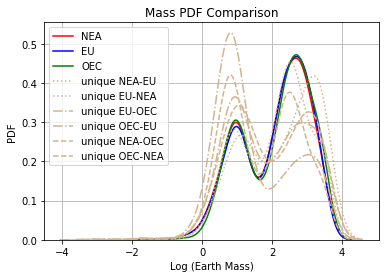

In [39]:
# Calculating mass statistics and plotting mass distributions

KSTest1 = ks_2samp(NEA_match, EU_match)
KSTest2 = ks_2samp(NEA_match, OEC_match)
KSTest3 = ks_2samp(EU_match, OEC_match)
ADTest1 = anderson_ksamp([NEA_match, EU_match])
ADTest2 = anderson_ksamp([NEA_match, OEC_match])
ADTest3 = anderson_ksamp([EU_match, OEC_match])
print(KSTest1,KSTest2,KSTest3)
print(ADTest1,ADTest2, ADTest3)

sns.kdeplot(NEA_match, color='r')
sns.kdeplot(EU_match, color='b')
sns.kdeplot(OEC_match, color='g')
sns.kdeplot(NEA_EU_nomatch, color='tan', linestyle="dotted")
sns.kdeplot(EU_NEA_nomatch, color='tan', linestyle="dotted")
sns.kdeplot(EU_OEC_nomatch, color='tan', linestyle="-.")
sns.kdeplot(OEC_EU_nomatch, color='tan', linestyle="-.")
sns.kdeplot(NEA_OEC_nomatch, color='tan', linestyle="--")
sns.kdeplot(OEC_NEA_nomatch, color='tan', linestyle="--")
# sns.kdeplot(Only_NEA, color='tan', linestyle="dotted")
# sns.kdeplot(Only_EU, color='tan', linestyle="-.")
# sns.kdeplot(Only_OEC, color='tan', linestyle="--")

plt.xlabel('Log (Earth Mass)')
plt.ylabel('PDF')
plt.title('Mass PDF Comparison')
plt.legend(["NEA", "EU", "OEC", "unique NEA-EU", "unique EU-NEA", "unique EU-OEC", "unique OEC-EU", "unique NEA-OEC", "unique OEC-NEA"])
plt.grid()

# Radius Parameter

In [40]:
# Matching Planets for NEA and EU

NEA_EU_match_names = []
NEA_EU_nomatch = []
NEA_OEC_nomatch = []
EU_NEA_nomatch = []
EU_OEC_nomatch = []
OEC_NEA_nomatch = []
OEC_EU_nomatch = []
for i in range(0, len(df_NEA)):
    match_idx = np.where(df_NEA.name[i] == df_EU.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size != 0:
        NEA_EU_match_names.append(df_NEA.name[i])
    else:
        NEA_EU_nomatch.append(df_NEA.radius[i])

df_NEA_EU_match_names = ps.DataFrame(NEA_EU_match_names, columns=['name'])

In [41]:
# Obtaining unique subsets

for i in range(0, len(df_EU)):
    match_idx = np.where(df_EU.name[i] == df_NEA.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        EU_NEA_nomatch.append(df_EU.radius[i])

######################################################################################

for i in range(0, len(df_NEA)):
    match_idx = np.where(df_NEA.name[i] == df_OEC.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        NEA_OEC_nomatch.append(df_NEA.radius[i])

######################################################################################
for i in range(0, len(df_OEC)):
    match_idx = np.where(df_OEC.name[i] == df_NEA.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        OEC_NEA_nomatch.append(df_OEC.radius[i])

######################################################################################
for i in range(0, len(df_EU)):
    match_idx = np.where(df_EU.name[i] == df_OEC.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        EU_OEC_nomatch.append(df_EU.radius[i])

######################################################################################
for i in range(0, len(df_OEC)):
    match_idx = np.where(df_OEC.name[i] == df_EU.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        OEC_EU_nomatch.append(df_OEC.radius[i])

In [42]:
# Matching planets for NEA, EU and OEC

NEA_EU_OEC_match_names = []
Only_OEC = []
OEC_match = []
for i in range(0, len(df_OEC)):
    match_idx = np.where(df_OEC.name[i] == df_NEA_EU_match_names.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        Only_OEC.append(df_OEC.radius[i])

    else:
        NEA_EU_OEC_match_names.append(df_OEC.name[i])
        OEC_match.append(df_OEC.radius[int(match_idx)])


df_NEA_EU_OEC_match_names = ps.DataFrame(NEA_EU_OEC_match_names, columns=['name'])

In [43]:
# Obtaining NEA match and EU match

Only_NEA = []
NEA_match = []
Only_EU = []
EU_match = []
for i in range(0, len(df_NEA)):
    match_idx = np.where(df_NEA.name[i] == df_NEA_EU_OEC_match_names.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        Only_NEA.append(df_NEA.radius[i])

    else:
        NEA_match.append(df_NEA.radius[i])

for i in range(0, len(df_EU)):
    match_idx = np.where(df_EU.name[i] == df_NEA_EU_OEC_match_names.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        Only_EU.append(df_EU.radius[i])

    else:
        EU_match.append(df_EU.radius[i])

In [44]:
# Converting Jupiter radii to Log Earth radii

for i in range(0, len(NEA_match)):
    NEA_match[i] = 11.2089*(NEA_match[i])
    EU_match[i] = 11.2089*(EU_match[i])
    OEC_match[i] = 11.2089*(OEC_match[i])

    NEA_match[i] = math.log10(NEA_match[i])
    EU_match[i] = math.log10(EU_match[i])
    OEC_match[i] = math.log10(OEC_match[i])

######################################################################################
for i in range(0, len(NEA_EU_nomatch)):
    NEA_EU_nomatch[i] = 11.2089*(NEA_EU_nomatch[i])
    NEA_EU_nomatch[i] = math.log10(NEA_EU_nomatch[i])

for i in range(0, len(EU_NEA_nomatch)):
    EU_NEA_nomatch[i] = 11.2089*(EU_NEA_nomatch[i])
    EU_NEA_nomatch[i] = math.log10(EU_NEA_nomatch[i])

for i in range(0, len(EU_OEC_nomatch)):
    EU_OEC_nomatch[i] = 11.2089*(EU_OEC_nomatch[i])
    EU_OEC_nomatch[i] = math.log10(EU_OEC_nomatch[i])

for i in range(0, len(OEC_EU_nomatch)):
    OEC_EU_nomatch[i] = 11.2089*(OEC_EU_nomatch[i])
    OEC_EU_nomatch[i] = math.log10(OEC_EU_nomatch[i])

for i in range(0, len(NEA_OEC_nomatch)):
    NEA_OEC_nomatch[i] = 11.2089*(NEA_OEC_nomatch[i])
    NEA_OEC_nomatch[i] = math.log10(NEA_OEC_nomatch[i])

for i in range(0, len(OEC_NEA_nomatch)):
    OEC_NEA_nomatch[i] = 11.2089*(OEC_NEA_nomatch[i])
    OEC_NEA_nomatch[i] = math.log10(OEC_NEA_nomatch[i])

<ipython-input-45-ccd06c60cf35>:6: UserWarning: p-value floored: true value smaller than 0.001
  ADTest1 = anderson_ksamp([NEA_match, EU_match])
<ipython-input-45-ccd06c60cf35>:7: UserWarning: p-value floored: true value smaller than 0.001
  ADTest2 = anderson_ksamp([NEA_match, OEC_match])
<ipython-input-45-ccd06c60cf35>:8: UserWarning: p-value floored: true value smaller than 0.001
  ADTest3 = anderson_ksamp([EU_match, OEC_match])


KstestResult(statistic=0.0425531914893617, pvalue=0.2589069181107568) KstestResult(statistic=0.031914893617021274, pvalue=0.6140432050099409) KstestResult(statistic=0.03546099290780142, pvalue=0.47749460966697926)
Anderson_ksampResult(statistic=5144.208038070064, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001) Anderson_ksampResult(statistic=1651.448598063031, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001) Anderson_ksampResult(statistic=967.4109333743291, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)


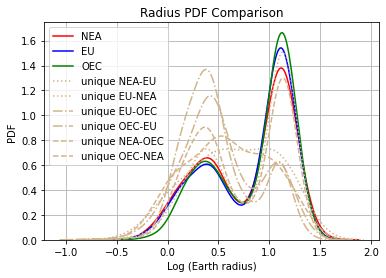

In [45]:
# Calculating radius statistics and plotting distributions

KSTest1 = ks_2samp(NEA_match, EU_match)
KSTest2 = ks_2samp(NEA_match, OEC_match)
KSTest3 = ks_2samp(EU_match, OEC_match)
ADTest1 = anderson_ksamp([NEA_match, EU_match])
ADTest2 = anderson_ksamp([NEA_match, OEC_match])
ADTest3 = anderson_ksamp([EU_match, OEC_match])
print(KSTest1,KSTest2,KSTest3)
print(ADTest1,ADTest2, ADTest3)

sns.kdeplot(NEA_match, color='r')
sns.kdeplot(EU_match, color='b')
sns.kdeplot(OEC_match, color='g')
sns.kdeplot(NEA_EU_nomatch, color='tan', linestyle="dotted")
sns.kdeplot(EU_NEA_nomatch, color='tan', linestyle="dotted")
sns.kdeplot(EU_OEC_nomatch, color='tan', linestyle="-.")
sns.kdeplot(OEC_EU_nomatch, color='tan', linestyle="-.")
sns.kdeplot(NEA_OEC_nomatch, color='tan', linestyle="--")
sns.kdeplot(OEC_NEA_nomatch, color='tan', linestyle="--")

plt.xlabel('Log (Earth radius)')
plt.ylabel('PDF')
plt.title('Radius PDF Comparison')
plt.legend(["NEA", "EU", "OEC", "unique NEA-EU", "unique EU-NEA", "unique EU-OEC", "unique OEC-EU", "unique NEA-OEC", "unique OEC-NEA"])
plt.grid()

# Data Analysis - Orbital Period

In [46]:
# Matching Planets for NEA and EU

NEA_EU_match_names = []
NEA_EU_nomatch = []
NEA_OEC_nomatch = []
EU_NEA_nomatch = []
EU_OEC_nomatch = []
OEC_NEA_nomatch = []
OEC_EU_nomatch = []
for i in range(0, len(df_NEA)):
    match_idx = np.where(df_NEA.name[i] == df_EU.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size != 0:
        NEA_EU_match_names.append(df_NEA.name[i])
    else:
        NEA_EU_nomatch.append(df_NEA.orbper[i])


df_NEA_EU_match_names = ps.DataFrame(NEA_EU_match_names, columns=['name'])

In [47]:
# Obtaining unique subsets

for i in range(0, len(df_EU)):
    match_idx = np.where(df_EU.name[i] == df_NEA.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        EU_NEA_nomatch.append(df_EU.orbper[i])

######################################################################################

for i in range(0, len(df_NEA)):
    match_idx = np.where(df_NEA.name[i] == df_OEC.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        NEA_OEC_nomatch.append(df_NEA.orbper[i])

######################################################################################
for i in range(0, len(df_OEC)):
    match_idx = np.where(df_OEC.name[i] == df_NEA.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        OEC_NEA_nomatch.append(df_OEC.orbper[i])

######################################################################################
for i in range(0, len(df_EU)):
    match_idx = np.where(df_EU.name[i] == df_OEC.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        EU_OEC_nomatch.append(df_EU.orbper[i])

######################################################################################
for i in range(0, len(df_OEC)):
    match_idx = np.where(df_OEC.name[i] == df_EU.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        OEC_EU_nomatch.append(df_OEC.orbper[i])

In [48]:
# Matching planets for NEA, EU and OEC

NEA_EU_OEC_match_names = []
Only_OEC = []
OEC_match = []
for i in range(0, len(df_OEC)):
    match_idx = np.where(df_OEC.name[i] == df_NEA_EU_match_names.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        Only_OEC.append(df_OEC.orbper[i])

    else:
        NEA_EU_OEC_match_names.append(df_OEC.name[i])
        OEC_match.append(df_OEC.orbper[int(match_idx)])


df_NEA_EU_OEC_match_names = ps.DataFrame(NEA_EU_OEC_match_names, columns=['name'])


Only_NEA = []
NEA_match = []
Only_EU = []
EU_match = []
for i in range(0, len(df_NEA)):
    match_idx = np.where(df_NEA.name[i] == df_NEA_EU_OEC_match_names.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        Only_NEA.append(df_NEA.orbper[i])

    else:
        NEA_match.append(df_NEA.orbper[i])

for i in range(0, len(df_EU)):
    match_idx = np.where(df_EU.name[i] == df_NEA_EU_OEC_match_names.name)[0]
    match_idx_size = match_idx.size

    if match_idx_size == 0:
        Only_EU.append(df_EU.orbper[i])

    else:
        EU_match.append(df_EU.orbper[i])

In [49]:
# Converting Orbital Period to Log Orbital Period

for i in range(0, len(NEA_match)):
    NEA_match[i] = math.log10(NEA_match[i])
    EU_match[i] = math.log10(EU_match[i])
    OEC_match[i] = math.log10(OEC_match[i])

for i in range(0, len(Only_NEA)):
    Only_NEA[i] = math.log10(Only_NEA[i])

for i in range(0, len(Only_EU)):
    Only_EU[i] = math.log10(Only_EU[i])

for i in range(0, len(Only_OEC)):
    Only_OEC[i] = math.log10(Only_OEC[i])

###############################################################
for i in range(0, len(NEA_EU_nomatch)):
    NEA_EU_nomatch[i] = math.log10(NEA_EU_nomatch[i])

for i in range(0, len(EU_NEA_nomatch)):
    EU_NEA_nomatch[i] = math.log10(EU_NEA_nomatch[i])

for i in range(0, len(EU_OEC_nomatch)):
    EU_OEC_nomatch[i] = math.log10(EU_OEC_nomatch[i])

for i in range(0, len(OEC_EU_nomatch)):
    OEC_EU_nomatch[i] = math.log10(OEC_EU_nomatch[i])

for i in range(0, len(NEA_OEC_nomatch)):
    NEA_OEC_nomatch[i] = math.log10(NEA_OEC_nomatch[i])

for i in range(0, len(OEC_NEA_nomatch)):
    OEC_NEA_nomatch[i] = math.log10(OEC_NEA_nomatch[i])

<ipython-input-50-62cbd79f326f>:6: UserWarning: p-value capped: true value larger than 0.25
  ADTest1 = anderson_ksamp([NEA_match, EU_match])
<ipython-input-50-62cbd79f326f>:7: UserWarning: p-value floored: true value smaller than 0.001
  ADTest2 = anderson_ksamp([NEA_match, OEC_match])
<ipython-input-50-62cbd79f326f>:8: UserWarning: p-value floored: true value smaller than 0.001
  ADTest3 = anderson_ksamp([EU_match, OEC_match])


KstestResult(statistic=0.0062056737588652485, pvalue=1.0) KstestResult(statistic=0.044326241134751775, pvalue=0.21779651442999928) KstestResult(statistic=0.0398936170212766, pvalue=0.3307753230763342)
Anderson_ksampResult(statistic=0.22847478451093545, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25) Anderson_ksampResult(statistic=157.25452564471456, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001) Anderson_ksampResult(statistic=127.21616762802881, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)


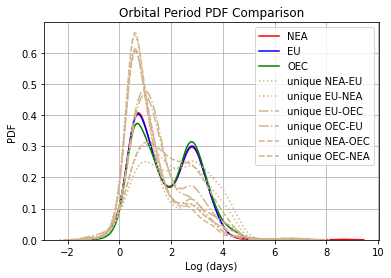

In [50]:
# Calculating orbital period statistics and plotting distributions

KSTest1 = ks_2samp(NEA_match, EU_match)
KSTest2 = ks_2samp(NEA_match, OEC_match)
KSTest3 = ks_2samp(EU_match, OEC_match)
ADTest1 = anderson_ksamp([NEA_match, EU_match])
ADTest2 = anderson_ksamp([NEA_match, OEC_match])
ADTest3 = anderson_ksamp([EU_match, OEC_match])
print(KSTest1,KSTest2,KSTest3)
print(ADTest1,ADTest2, ADTest3)

sns.kdeplot(NEA_match, color='r')
sns.kdeplot(EU_match, color='b')
sns.kdeplot(OEC_match, color='g')
sns.kdeplot(NEA_EU_nomatch, color='tan', linestyle="dotted")
sns.kdeplot(EU_NEA_nomatch, color='tan', linestyle="dotted")
sns.kdeplot(EU_OEC_nomatch, color='tan', linestyle="-.")
sns.kdeplot(OEC_EU_nomatch, color='tan', linestyle="-.")
sns.kdeplot(NEA_OEC_nomatch, color='tan', linestyle="--")
sns.kdeplot(OEC_NEA_nomatch, color='tan', linestyle="--")
sns.kdeplot(Only_NEA, color='tan', linestyle="dotted")
sns.kdeplot(Only_EU, color='tan', linestyle="-.")
sns.kdeplot(Only_OEC, color='tan', linestyle="--")

plt.xlabel('Log (days)')
plt.ylabel('PDF')
plt.title('Orbital Period PDF Comparison')
plt.legend(["NEA", "EU", "OEC", "unique NEA-EU", "unique EU-NEA", "unique EU-OEC", "unique OEC-EU", "unique NEA-OEC", "unique OEC-NEA"])
plt.grid()

## Biases

The first thing that can be noticed from these plots are detection biases. For example in the mass KDE plot, we are more likely to detect masses at about 10 Earth masses and about 316 $M_{\bigoplus}$ ($10^{2.5}$) than at about 56 $M_{\bigoplus}$ ($10^{1.75}$). These biases are a direct result of our current detection methods. For instance, planets found around 316 $M_{\bigoplus}$ have a high likelihood of having been detected through the radial velocity method since this detection method is biased towards more massive planets. The high density of smaller planets at 10 $M_{\bigoplus}$ are planets mostly detected through the transit method which is reasonable since these planets mostly have relatively shorter orbital periods.

For radius, it seems that we mostly detect planets at about 2.37 $R_{\bigoplus}$ ($10^{0.375}$) with a sudden rise in density at 13.3 $R_{\bigoplus}$ ($10^{1.125}$). The planets around 13.3 $R_{\bigoplus}$ are mostly made up of objects discovered through the transit method. This is nothing surprising since planets with larger radii produce appreciable light curves when passing in front of their host stars and are thus more easily detected.

For Orbital period, so far, we only seem to be detecting planets with orbital periods of about 10 days. This is because for longer periods, it is difficult to confirm the discovery of a planet using solely indirect detection methods which are the methods that make up the majority of our exoplanet discoveries.

## Differences

For mass comparison, there is a high number of mostly transit planets at 10 $M_{\bigoplus}$ for all unique subsets but especially EU. This is an interesting finding because the transit method does not allow for the mass of an object to be resolved directly. Only an upper mass estimate can be calculated and NEA, EU and OEC all treat this estimate differently. EU inputs the value as a nominal mass value while NEA and OEC generally treats it as an upper mass limit or completely omits it. This difference is a direct consequence of the different inclusion criteria of the databases.

For radius comparison, the NEA-OEC unique subset has a relatively higher density of planets at 13.3 $R_{\bigoplus}$ ($10^{1.125}$). For this unique subset specifically, multiple papers revealed that these planets have had their radii calculated using a theoretical mass-radius relation. These planets also have surprisingly short periods which means that there could be tidal forces affecting the radii of the planets. While NEA chooses to include these theoretical values, OEC and EU do not.